In [1]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import numpy as np
import random

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "data/Set_E_face_images_1000_stim/faces_1000/"

files = []

for dir in os.listdir(data_dir):
    if dir.startswith('.'):
        continue
    num = int(dir[2:])
 
    files.append(os.path.join(data_dir, dir))

class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, inverted=False):
        self.file_list = file_list
        self.n_class = len(file_list)
        self.inverted = inverted
        
        self.file_list_image_paths = [[] for _ in range(self.n_class)]
        for idx, file in enumerate(self.file_list):
            for image_file in os.listdir(file):
                if image_file.endswith('.jpg'):
                    self.file_list_image_paths[idx].append(os.path.join(file, image_file))
        
        for i in range(self.n_class):
            assert len(self.file_list_image_paths[i]) == 10, f"Expected 10 images per person, found {len(self.file_list_image_paths[i])} in {self.file_list[i]}"
            

    def __len__(self):
        return len(self.file_list) * 10

    def load_image(self, image_path, inverted):
        from PIL import Image
        import torchvision.transforms as transforms
        
        image = Image.open(image_path).convert('RGB')
        if inverted:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.RandomVerticalFlip(p=1.0)
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        return transform(image)

    def __getitem__(self, idx):
        file_idx = idx // 10
        image_idx = idx % 10
        image_path = self.file_list_image_paths[file_idx][image_idx]
        
        image = self.load_image(image_path, self.inverted)
        return image

dataset = FaceDataset(files, inverted=False)
inverted_dataset = FaceDataset(files, inverted=True)

print(f"dataset size: {len(dataset)}")


dataset size: 1000


In [4]:
# ImageNet pretrained ViT on upright images

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads = nn.Identity()
model = model.to(device)

num_correct = 0
total = 0
all_acc = []

num_people = len(files)
for p1 in tqdm(range(num_people), desc='matching pairs'):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = dataset[p1_idx].unsqueeze(0).to(device)
        image2 = dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = model(image1)
            embedding2 = model(image2)
            target_embedding = model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1
        all_acc.append(num_correct/total)
        
print(f"final accuracy: {num_correct / total * 100:.2f}%")

matching pairs: 100%|██████████| 100/100 [02:54<00:00,  1.75s/it]

final accuracy: 84.91%


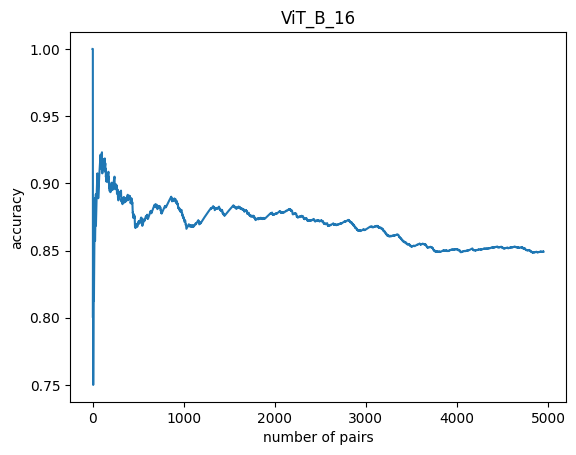

In [5]:
import matplotlib.pyplot as plt

plt.plot(all_acc)
plt.xlabel("number of pairs")
plt.ylabel("accuracy")
plt.title("ViT_B_16")
plt.show()

In [6]:
# ViT_B_16 Fine-tuned (10 epochs) on vggface2_subset test on upright images

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads = nn.Identity()
model.load_state_dict(torch.load("vit_b_face_finetuned.pth"))
model = model.to(device)

num_correct = 0
total = 0
all_acc2 = []

num_people = len(files)
for p1 in tqdm(range(num_people), desc='matching pairs'):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = dataset[p1_idx].unsqueeze(0).to(device)
        image2 = dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = model(image1)
            embedding2 = model(image2)
            target_embedding = model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1
        all_acc2.append(num_correct/total)
        
print(f"final accuracy: {num_correct / total * 100:.2f}%")

matching pairs: 100%|██████████| 100/100 [03:28<00:00,  2.08s/it]

final accuracy: 80.73%


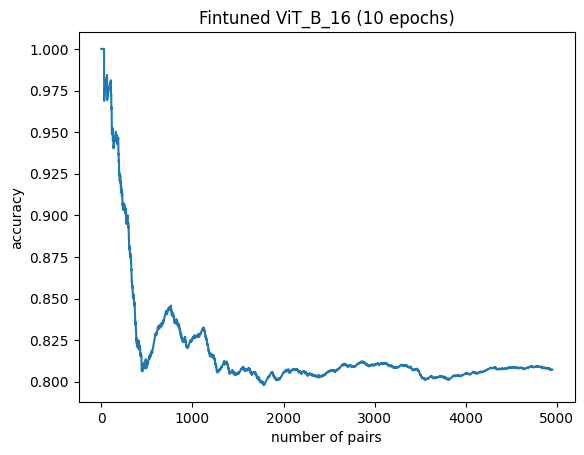

In [7]:
plt.plot(all_acc2)
plt.xlabel("number of pairs")
plt.ylabel("accuracy")
plt.title("Fintuned ViT_B_16 (10 epochs)")
plt.show()

In [8]:
# ViT_B_16 Fine-tuned (20 epochs) on vggface2_subset test on upright images

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads = nn.Identity()
model.load_state_dict(torch.load("vit_b_face_finetuned20.pth"))
model = model.to(device)

num_correct = 0
total = 0
all_acc3 = []

num_people = len(files)
for p1 in tqdm(range(num_people), desc='matching pairs'):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = dataset[p1_idx].unsqueeze(0).to(device)
        image2 = dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = model(image1)
            embedding2 = model(image2)
            target_embedding = model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1
        all_acc3.append(num_correct/total)
        
print(f"final accuracy: {num_correct / total * 100:.2f}%")

matching pairs: 100%|██████████| 100/100 [03:42<00:00,  2.22s/it]

final accuracy: 82.28%


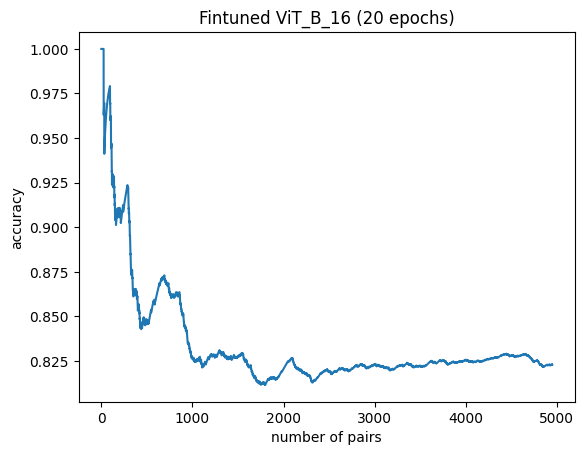

In [9]:
plt.plot(all_acc3)
plt.xlabel("number of pairs")
plt.ylabel("accuracy")
plt.title("Fintuned ViT_B_16 (20 epochs)")
plt.show()

In [10]:
# ViT_B_16 on inverted faces

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads = nn.Identity()
model = model.to(device)

num_correct = 0
total = 0
all_acc4 = []

num_people = len(files)
for p1 in tqdm(range(num_people), desc='matching pairs'):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = inverted_dataset[p1_idx].unsqueeze(0).to(device)
        image2 = inverted_dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = inverted_dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = model(image1)
            embedding2 = model(image2)
            target_embedding = model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1
        all_acc4.append(num_correct/total)
        
print(f"final accuracy: {num_correct / total * 100:.2f}%")

matching pairs: 100%|██████████| 100/100 [04:02<00:00,  2.43s/it]

final accuracy: 80.57%


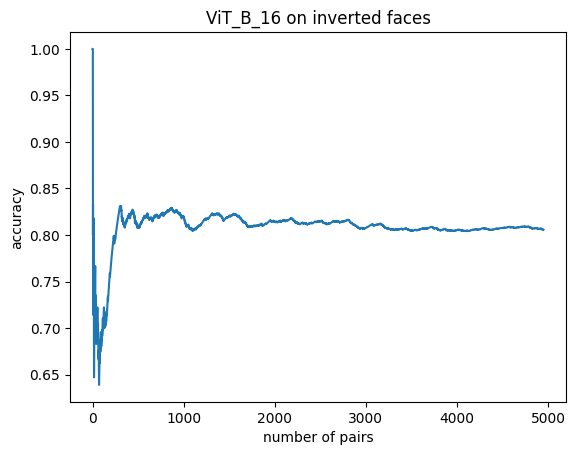

In [11]:
plt.plot(all_acc4)
plt.xlabel("number of pairs")
plt.ylabel("accuracy")
plt.title("ViT_B_16 on inverted faces")
plt.show()

In [12]:
# ViT_B_16 Fine-tuned (10 epochs) on vggface2_subset test on inverted images

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads = nn.Identity()
model.load_state_dict(torch.load("vit_b_face_finetuned.pth"))
model = model.to(device)

num_correct = 0
total = 0
all_acc5 = []

num_people = len(files)
for p1 in tqdm(range(num_people), desc='matching pairs'):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = inverted_dataset[p1_idx].unsqueeze(0).to(device)
        image2 = inverted_dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = inverted_dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = model(image1)
            embedding2 = model(image2)
            target_embedding = model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1
        all_acc5.append(num_correct/total)
        
print(f"final accuracy: {num_correct / total * 100:.2f}%")

matching pairs: 100%|██████████| 100/100 [04:15<00:00,  2.55s/it]

final accuracy: 69.29%


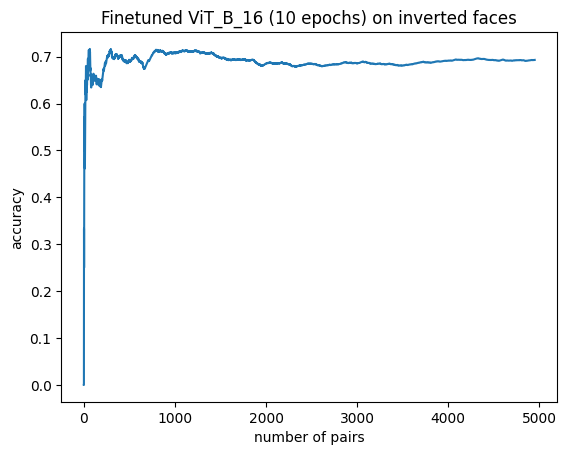

In [13]:
plt.plot(all_acc5)
plt.xlabel("number of pairs")
plt.ylabel("accuracy")
plt.title("Finetuned ViT_B_16 (10 epochs) on inverted faces")
plt.show()

In [14]:
# ViT_B_16 Fine-tuned (20 epochs) on vggface2_subset test on inverted images

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads = nn.Identity()
model.load_state_dict(torch.load("vit_b_face_finetuned20.pth"))
model = model.to(device)

num_correct = 0
total = 0
all_acc6 = []

num_people = len(files)
for p1 in tqdm(range(num_people), desc='matching pairs'):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = inverted_dataset[p1_idx].unsqueeze(0).to(device)
        image2 = inverted_dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = inverted_dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = model(image1)
            embedding2 = model(image2)
            target_embedding = model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1
        all_acc6.append(num_correct/total)
        
print(f"final accuracy: {num_correct / total * 100:.2f}%")

matching pairs: 100%|██████████| 100/100 [04:21<00:00,  2.62s/it]

final accuracy: 71.43%


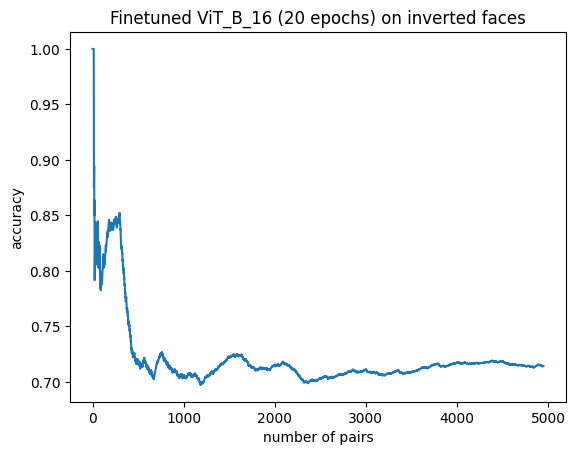

In [15]:
plt.plot(all_acc6)
plt.xlabel("number of pairs")
plt.ylabel("accuracy")
plt.title("Finetuned ViT_B_16 (20 epochs) on inverted faces")
plt.show()

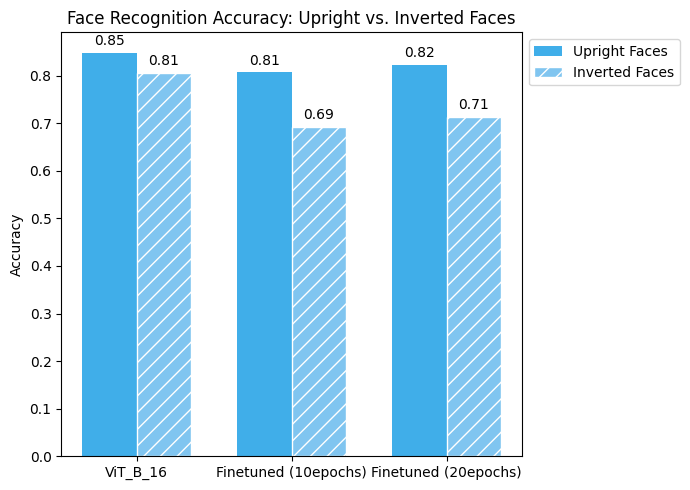

In [38]:
import matplotlib.pyplot as plt
import numpy as np

models = ['ViT_B_16', 'Finetuned (10epochs)', 'Finetuned (20epochs)']

upright_acc = [all_acc[-1], all_acc2[-1], all_acc3[-1]]
inverted_acc = [all_acc4[-1], all_acc5[-1], all_acc6[-1]]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))

bars_upright = ax.bar(x - width/2, upright_acc, width, label='Upright Faces', color="#40aee9")
bars_inverted = ax.bar(x + width/2, inverted_acc, width, label='Inverted Faces', hatch='//',edgecolor='white', color="#80c5f0")

ax.set_ylabel('Accuracy')
ax.set_title('Face Recognition Accuracy: Upright vs. Inverted Faces')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

for bar_group in [bars_upright, bars_inverted]:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
